# Submissions

Your submission should be packed as a **ZIPPED folder containing all predicted full floor plan configurations as IMAGES**. (The folder can be named to your liking.) Images should have the following properties:

- **size**: **512 x 512**;
- **compression technique**: **PNG**;
- **naming**: based on the naming in the test set, *e.g.*, "4167.png".

## IMPORTANT 1: Positioning
The floor plan should be correctly **positioned** in the image (!!). This means that the real location of a pixel should align with the location provided in the `struct_in` folder of the test set. The locations of the pixels are in the 2nd and 3rd channel of the corresponding `.npy` arrays. The locations (xs and ys) are extracted as follows:

In [23]:
import numpy as np
import os

# Define path
path_struct = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge\test\struct_in'  # change this to your own path (!)
id = 4167

# Load structural components (as 3D array)
stack = np.load(os.path.join(path_struct, f'{id}.npy'))

# Get structural component as binary map
struct = stack[..., 0].astype(np.uint8)  # structure as 2D (int) array

# Important part here: GET LOCATIONS OF ALL PIXELS
xs = stack[..., 1]  # x-locations as 2D (float) array
ys = stack[..., 2]  # y-locations as 2D (float) array

# Print locations
print(f'X locations:\n{xs}\n\n'
      f'Y locations:\n{ys}')


X locations:
[[-11.65 -11.57 -11.5  ...  24.58  24.66  24.72]
 [-11.65 -11.57 -11.5  ...  24.58  24.66  24.72]
 [-11.65 -11.57 -11.5  ...  24.58  24.66  24.72]
 ...
 [-11.65 -11.57 -11.5  ...  24.58  24.66  24.72]
 [-11.65 -11.57 -11.5  ...  24.58  24.66  24.72]
 [-11.65 -11.57 -11.5  ...  24.58  24.66  24.72]]

Y locations:
[[-18.36 -18.36 -18.36 ... -18.36 -18.36 -18.36]
 [-18.3  -18.3  -18.3  ... -18.3  -18.3  -18.3 ]
 [-18.22 -18.22 -18.22 ... -18.22 -18.22 -18.22]
 ...
 [ 17.86  17.86  17.86 ...  17.86  17.86  17.86]
 [ 17.92  17.92  17.92 ...  17.92  17.92  17.92]
 [ 18.    18.    18.   ...  18.    18.    18.  ]]


In the case above, x locations and y locations range from -11.65 to 24.72 and from -18.36 to 18.00. These are in actual meters (!)

## IMPORTANT 2: Class labels
The floor plan images should have the **correct pixel values**: pixels should corresponds to the correct classes. The range of classes is given here:

In [7]:
from constants import ROOM_NAMES

# Define class mapping (equivalent to order)
class_mapping = {cat: index for index, cat in enumerate(ROOM_NAMES)}

# Print categories and corresponding classes
print(f'Categories and classes:\n\t{class_mapping}')

Categories and classes:
	{'Bedroom': 0, 'Livingroom': 1, 'Kitchen': 2, 'Dining': 3, 'Corridor': 4, 'Stairs': 5, 'Storeroom': 6, 'Bathroom': 7, 'Balcony': 8, 'Structure': 9, 'Door': 10, 'Entrance Door': 11, 'Window': 12}


The last three categories (classes) are omitted in the evaluation, being specifically: "Door", "Entrance Door", and "Window".

## Creating a valid and correct submission

Here, we simply show how to do it when creating random 512 x 512 images containing the following valid pixel values ({1,2,3,4,5,6,7,8,9,13}):

In [14]:
from PIL import Image
from tqdm.auto import tqdm

# Set valid pixel values
VALID_CLASSES = np.array([1,2,3,4,5,6,7,8,9,13])

# Define a directory for saving your images
save = './codalab/submission/submission_random'  # make sure it exists (!)

# Loop through list
for f in tqdm(os.listdir(path_struct)):

      # Get identity
      id = int(f[:-4])  # get rid of .npy

      # Generate random array (with valid classes)
      random_array = np.random.choice(VALID_CLASSES, size=(512, 512))

      # Save random array as PNG image
      img = Image.fromarray(random_array)
      img.save(os.path.join(save, f'{id}.png'))

  0%|          | 0/1390 [00:00<?, ?it/s]

What remains:

Zip all the files in the folder into one ZIP archive. Make sure that ZIP archive IS NOT NESTED: the image files should be directly in the main folder.

## Extra: evaluation

The mean IoU is used:

In [19]:
import torch

def mean_iou(pred_mask, mask, classes, smooth=1e-10):

    """
    Computes the mean Intersection-over-Union between two masks;
    the predicted multi-class segmentation mask and the ground truth.
    """

    # make directly equipable when training (set grad off)
    with torch.no_grad():

        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for c in classes:  #loop over possible classes

            # compute masks per class
            true_class = pred_mask == c
            true_label = mask == c

            # when label does not exist in the ground truth, set to NaN
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)

        return np.nanmean(iou_per_class)

Let's evaluate our randomly generated arrays:

In [15]:
# Define reference and submission roots
ref_root = r'.\codalab\reference\reference_img'  # Be aware that you do NOT have access to this
sub_root = r'.\codalab\submission\submission_random'

# Get identity sets for reference and submission
ids_ref = set([int(f[:-4]) for f in os.listdir(ref_root)])
ids_sub = set([int(f[:-4]) for f in os.listdir(sub_root)])
overlap = ids_ref.intersection(ids_sub)

# Print reference and submission identity properties
# Overlap should be the full set (!)
print(f'Length dataset REF:\t{len(ids_ref)}')
print(f'Length dataset SUB:\t{len(ids_sub)}')
print(f'Length of overlap:\t{len(overlap)}')

Length dataset REF:	1390
Length dataset SUB:	1390
Length of overlap:	1390


That's a good start: full overlap! Let's check the shape of an arbitrarily chosen instance:

In [16]:
id = list(ids_sub)[3]
img_sub = np.asarray(Image.open(os.path.join(sub_root, f'{id}.png')))
img_ref = np.asarray(Image.open(os.path.join(ref_root, f'{id}.png')))

print(img_sub.shape)
print(img_ref.shape)

(512, 512)
(512, 512)


That is OK as well. Let's plot some examples.

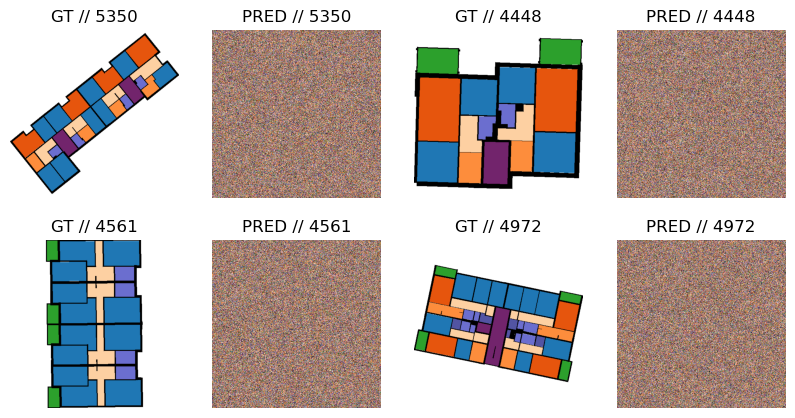

In [17]:
import random
import matplotlib.pyplot as plt
from utils import colorize_floorplan
from constants import CMAP_ROOMTYPE

CLASSES = list(map(class_mapping.get, ROOM_NAMES))

n = 2
fs = 2.5
_, axs = plt.subplots(ncols=n*2, nrows=n, figsize=(fs*2*n, fs*n))
axs = axs.flatten()

ids_list = list(ids_sub)
random.Random(4).shuffle(ids_list)

for i, ax in enumerate(axs):

    id = ids_list[int(np.floor(i/2))]

    # GT
    if not i % 2:
        img_ref = np.asarray(Image.open(os.path.join(ref_root, f'{id}.png')))
        ax.imshow(colorize_floorplan(img_ref, classes=CLASSES, cmap=CMAP_ROOMTYPE))
        ax.set_title(f'GT // {id}')
        ax.axis('off')

    # PRED
    else:
        img_sub = np.asarray(Image.open(os.path.join(sub_root, f'{id}.png')))
        ax.imshow(colorize_floorplan(img_sub, classes=CLASSES, cmap=CMAP_ROOMTYPE))
        ax.set_title(f'PRED // {id}')
        ax.axis('off')

Predictions do not look good; but what would you expect? Let's compute the relevant scores:

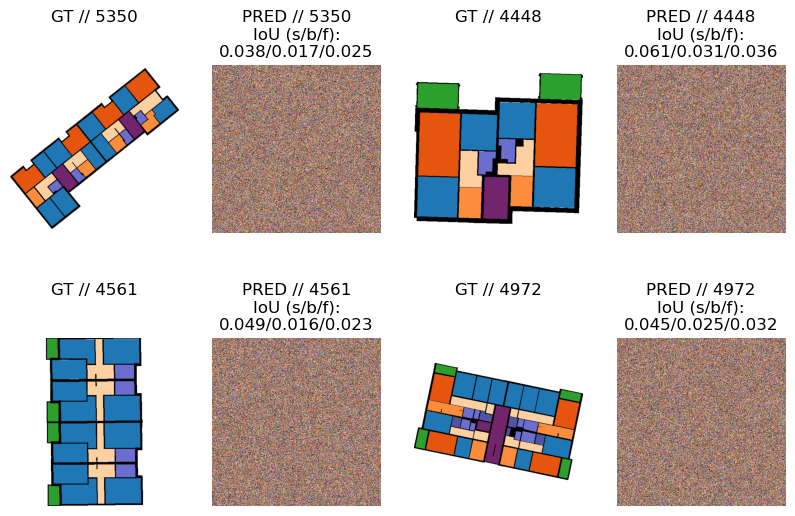

In [20]:
_, axs = plt.subplots(ncols=n*2, nrows=n, figsize=(fs*2*n, fs*n*1.3))
axs = axs.flatten()

for i in range(int(n**2)):

    id = ids_list[i]
    img_ref = torch.tensor(np.asarray(Image.open(os.path.join(ref_root, f'{id}.png'))))
    img_sub = torch.tensor(np.asarray(Image.open(os.path.join(sub_root, f'{id}.png'))))

    iou_struct = mean_iou(img_ref, img_sub, classes=[9])
    iou_woback = mean_iou(img_ref, img_sub, classes=CLASSES)
    iou_full = mean_iou(img_ref, img_sub, classes=CLASSES + [13])

    # GT
    ax = axs[2*i]
    ax.imshow(colorize_floorplan(img_ref, classes=CLASSES, cmap=CMAP_ROOMTYPE))
    ax.set_title(f'GT // {id}\n\n')
    ax.axis('off')
    ax.set_aspect('equal')

    # PRED
    ax = axs[2*i+1]
    ax.imshow(colorize_floorplan(img_sub, classes=CLASSES, cmap=CMAP_ROOMTYPE))
    ax.set_title(f'PRED // {id}\nIoU (s/b/f):\n{iou_struct:.3f}/{iou_woback:.3f}/{iou_full:.3f}')
    ax.axis('off')
    ax.set_aspect('equal')

Very bad scores indeed (0=terrible, 1=very good).